In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from model_evalulator import Evalulator
from oversampler import Oversampler

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

Using TensorFlow backend.


# Data Import

In [2]:
filepath = os.path.abspath(os.path.join(os.getcwd(),'data'))
image_filepath = filepath + '/image_arrays.npy'
label_filepath = filepath + '/image_labels.npy'
binary_label_filepath = filepath + '/binary_image_labels.npy'

data_array = np.load(image_filepath, allow_pickle = True)
labels_array = np.load(label_filepath, allow_pickle = True)
binary_labels_array = np.load(binary_label_filepath, allow_pickle = True)

data = {'images':data_array,'labels':labels_array}
binary_data = {'images':data_array,'labels':binary_labels_array}

In [3]:
numeric_labels = []
for i in data['labels']:
    if i == 'NonDemented':
        numeric_labels.append(0)
    elif i == 'VeryMildDemented':
        numeric_labels.append(1)
    elif i == 'MildDemented':
        numeric_labels.append(2)
    elif i == 'ModerateDemented':
        numeric_labels.append(3)
    else:
        raise Exception('Unknown label found.')
        
numeric_labels = np.array(numeric_labels)

## Reduce to 3 Labels

In [4]:
data2 = []
labels2 = []
labels2_name = []

for i in range(0,len(numeric_labels)):
    if numeric_labels[i] != 0:
        data2.append(data['images'][i])
        labels2.append(numeric_labels[i]-1)
        
for i in labels2:
    if i == 0:
        labels2_name.append('VeryMildDemented')
    elif i == 1:
        labels2_name.append('MildDemented')
    elif i == 2:
        labels2_name.append('ModerateDemented')
        
data2 = np.array(data2)
labels2 = np.array(labels2)

# Data Transformation

In [5]:
data2 = data2.astype('float32')
x = data2/255

print(x.shape)
x[0,:]

(3200, 208, 176, 3)


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [6]:
classes = 3
x_train, x_test, y_train, y_test = train_test_split(
    data2, labels2_name, test_size=0.33, random_state=50)

#y_train = to_categorical(y_train, classes)
#y_test = to_categorical(y_test, classes)

print(x_train.shape)
#print(y_train.shape)

(2144, 208, 176, 3)


# SMOTE

In [7]:
ov = Oversampler(x_train, y_train, .50)

In [8]:
artificial_images, new_image_count = ov.smote()

In [9]:
new_image_count

{'MildDemented': 322, 'ModerateDemented': 45, 'VeryMildDemented': 0}

In [10]:
ai = artificial_images['MildDemented'] + artificial_images['ModerateDemented'] + artificial_images['VeryMildDemented']
mild = ['MildDemented'] * new_image_count['MildDemented']
mod = ['ModerateDemented'] * new_image_count['ModerateDemented']
vmod = ['VeryMildDemented'] * new_image_count['VeryMildDemented']
ai_labels = mild+mod+vmod

ai = np.array(ai)

In [12]:
x_train2 = np.concatenate((x_train, ai), axis=0)
y_train2 = y_train + ai_labels

In [14]:
x_train2 = x_train2/255
x_test = x_test/255

y_train_num = []
for i in y_train2:
    if i == 'VeryMildDemented':
        y_train_num.append(0)
    elif i == 'MildDemented':
        y_train_num.append(1)
    elif i == 'ModerateDemented':
        y_train_num.append(2)
        
y_test_num = []
for i in y_test:
    if i == 'VeryMildDemented':
        y_test_num.append(0)
    elif i == 'MildDemented':
        y_test_num.append(1)
    elif i == 'ModerateDemented':
        y_test_num.append(2)
        
y_train = to_categorical(y_train_num, classes)
y_test = to_categorical(y_test_num, classes)

# Modeler

In [15]:
def create_model(input_shape, n_classes):
    print(input_shape, n_classes)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [5]:
data['images'].shape

(6400, 208, 176, 3)

# Model v1 (5-8-20)

In [7]:
model1 = create_model(x_train[0].shape, classes)
batch_size = 100
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1\
                     , validation_data=(x_test, y_test))

model1.evaluate(x_test, y_test)

Train on 4288 samples, validate on 2112 samples
Epoch 1/50
4288/4288 [==============================] - 21s 5ms/step - loss: 14.5265 - accuracy: 0.4566 - val_loss: 1.1277 - val_accuracy: 0.4986
Epoch 2/50
4288/4288 [==============================] - 16s 4ms/step - loss: 1.0844 - accuracy: 0.4890 - val_loss: 3.7088 - val_accuracy: 0.4986
Epoch 3/50
4288/4288 [==============================] - 16s 4ms/step - loss: 1.2350 - accuracy: 0.4909 - val_loss: 1.0225 - val_accuracy: 0.5000
Epoch 4/50
4288/4288 [==============================] - 16s 4ms/step - loss: 1.1442 - accuracy: 0.4893 - val_loss: 1.0967 - val_accuracy: 0.5166
Epoch 5/50
4288/4288 [==============================] - 16s 4ms/step - loss: 1.0387 - accuracy: 0.5187 - val_loss: 1.0692 - val_accuracy: 0.5057
Epoch 6/50
4288/4288 [==============================] - 16s 4ms/step - loss: 1.0256 - accuracy: 0.5159 - val_loss: 1.0407 - val_accuracy: 0.5279
Epoch 7/50
4288/4288 [==============================] - 16s 4ms/step - loss: 1.00

[0.12280548335702131, 0.9663825631141663]

In [8]:
model1.save('models/model_v1_06-28-2020')

In [18]:
from tensorflow.keras.models import load_model

test_load = load_model('models/model_v1_05-08-2020')

Text(0.5, 1.0, 'Accuracy Curves')

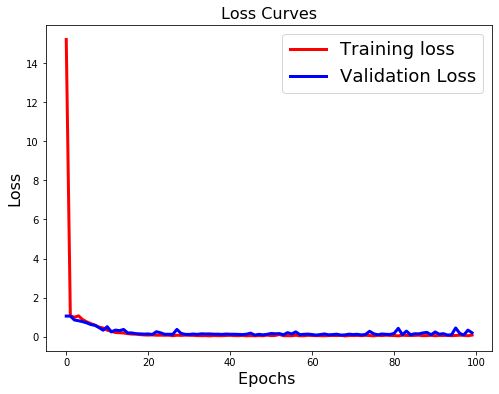

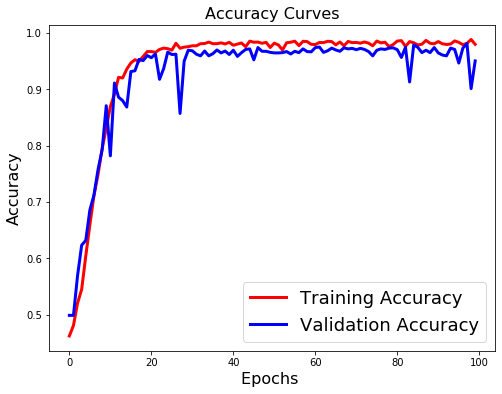

In [9]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [9]:
predictions = test_load.predict(x_test)

In [28]:
label_predictions = []

for i in predictions.argmax(axis=1):
    if i == 0:
        label_predictions.append('NonDemented')
    elif i == 1:
        label_predictions.append('VeryMildDemented')
    elif i == 2:
        label_predictions.append('MildDemented')
    elif i == 3:
        label_predictions.append('ModerateDemented')
    else:
        raise Exception('Index out of range. Please check your predictions.')
        
label_predictions = np.array(label_predictions)

In [22]:
true_labels = []

for i in y_test.argmax(axis=1):
    if i == 0:
        true_labels.append('NonDemented')
    elif i == 1:
        true_labels.append('VeryMildDemented')
    elif i == 2:
        true_labels.append('MildDemented')
    elif i == 3:
        true_labels.append('ModerateDemented')
    else:
        raise Exception('Index out of range. Please check your predictions.')
        
true_labels = np.array(true_labels)

## Stats and Confusion Matrix

In [34]:
len(ai_labels)

722

Accuracy: 0.23546
F1: 0.34223
Recall: 0.23546
Precision: 0.79317
Jaccard: 0.20658


C:\Users\sourp\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


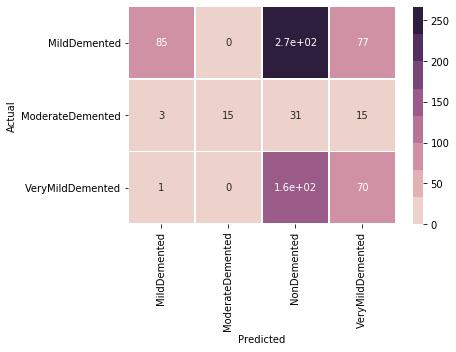

In [33]:
eval1 = Evalulator(ai_labels, label_predictions)

eval1.confusion_matrix()
eval1.stats()

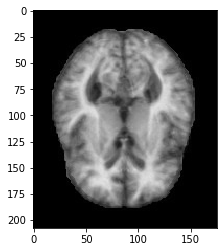

In [57]:
plt.imshow(np.rint(artificial_images['VeryMildDemented']).astype(int)[10])
#plt.imshow(data['images'][100])

## Gathering errors

In [10]:
errors_dict = {'image':[], 'true_label':[], 'predicted_label':[]}
for i in range(len(true_labels)):
    if true_labels[i] != label_predictions[i]:
        errors_dict['image'].append(x_test[i])
        errors_dict['true_label'].append(true_labels[i])
        errors_dict['predicted_label'].append(label_predictions[i])

NameError: name 'true_labels' is not defined

## SMOTE

In [9]:
ov = Oversampler(data['images'], data['labels'], .25)

In [10]:
artificial_images, new_image_count = ov.smote()

In [11]:
new_image_count

{'NonDemented': 0,
 'MildDemented': 429,
 'ModerateDemented': 64,
 'VeryMildDemented': 229}

In [12]:
ai = artificial_images['MildDemented'] + artificial_images['ModerateDemented'] + artificial_images['VeryMildDemented']
mild = ['MildDemented'] * new_image_count['MildDemented']
mod = ['ModerateDemented'] * new_image_count['ModerateDemented']
vmod = ['VeryMildDemented'] * new_image_count['VeryMildDemented']
ai_labels = mild+mod+vmod

In [18]:
ai = np.array(ai)

In [20]:
predictions = model1.predict(ai)

In [27]:
predictions[0]

array([8.6887622e-01, 7.7371314e-02, 5.3724509e-02, 2.7945767e-05],
      dtype=float32)

# Model v2 (7-4-20) -- uses scaled data

In [80]:
model2 = create_model(x_train[0].shape, classes)
batch_size = 100
epochs = 50
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1\
                     , validation_data=(x_test, y_test))

model2.evaluate(x_test, y_test)

(208, 176, 3) 4
Train on 4800 samples, validate on 1600 samples
Epoch 1/50
4800/4800 [==============================] - 24s 5ms/step - loss: 2.8231 - accuracy: 0.4742 - val_loss: 1.1380 - val_accuracy: 0.5113
Epoch 2/50
4800/4800 [==============================] - 15s 3ms/step - loss: 1.0487 - accuracy: 0.4900 - val_loss: 1.1343 - val_accuracy: 0.5113
Epoch 3/50
4800/4800 [==============================] - 15s 3ms/step - loss: 1.0649 - accuracy: 0.4927 - val_loss: 1.0294 - val_accuracy: 0.5256
Epoch 4/50
4800/4800 [==============================] - 15s 3ms/step - loss: 0.9917 - accuracy: 0.5267 - val_loss: 0.9309 - val_accuracy: 0.5525
Epoch 5/50
4800/4800 [==============================] - 15s 3ms/step - loss: 0.9058 - accuracy: 0.5844 - val_loss: 0.7944 - val_accuracy: 0.6225
Epoch 6/50
4800/4800 [==============================] - 15s 3ms/step - loss: 0.8020 - accuracy: 0.6306 - val_loss: 0.8065 - val_accuracy: 0.5919
Epoch 7/50
4800/4800 [==============================] - 16s 3ms/st

[0.06708627307914866, 0.9906250238418579]

In [81]:
model2.save('models/model_v2_07-04-2020')

Text(0.5, 1.0, 'Accuracy Curves')

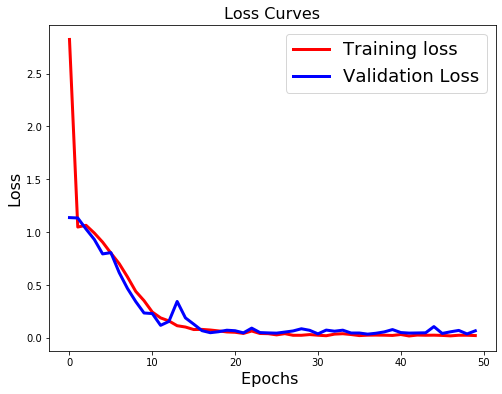

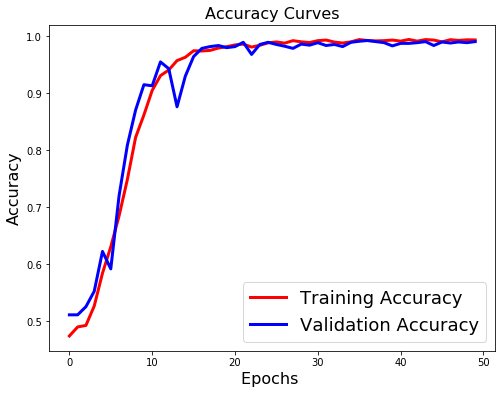

In [82]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['accuracy'],'r',linewidth=3.0)
plt.plot(history2.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Stats

In [83]:
predictions = model2.predict(x_test)

In [84]:
label_predictions = []

for i in predictions.argmax(axis=1):
    if i == 0:
        label_predictions.append('NonDemented')
    elif i == 1:
        label_predictions.append('VeryMildDemented')
    elif i == 2:
        label_predictions.append('MildDemented')
    elif i == 3:
        label_predictions.append('ModerateDemented')
    else:
        raise Exception('Index out of range. Please check your predictions.')
        
label_predictions = np.array(label_predictions)

In [85]:
true_labels = []

for i in y_test.argmax(axis=1):
    if i == 0:
        true_labels.append('NonDemented')
    elif i == 1:
        true_labels.append('VeryMildDemented')
    elif i == 2:
        true_labels.append('MildDemented')
    elif i == 3:
        true_labels.append('ModerateDemented')
    else:
        raise Exception('Index out of range. Please check your predictions.')
        
true_labels = np.array(true_labels)

Accuracy: 0.99062
F1: 0.99063
Recall: 0.99062
Precision: 0.99063
Jaccard: 0.98144


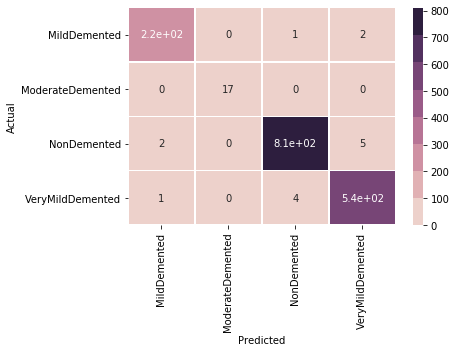

In [87]:
eval2 = Evalulator(true_labels, label_predictions)

eval2.confusion_matrix()
eval2.stats()

# Model v3 (7-4-20) -- No NonDemented

In [24]:
model3 = create_model(x_train[0].shape, classes)
batch_size = 100
epochs = 50
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1\
                     , validation_data=(x_test, y_test))

model3.evaluate(x_test, y_test)

(208, 176, 3) 3
Train on 2144 samples, validate on 1056 samples
Epoch 1/50
2144/2144 [==============================] - 9s 4ms/step - loss: 2.3319 - accuracy: 0.6413 - val_loss: 0.7090 - val_accuracy: 0.6903
Epoch 2/50
2144/2144 [==============================] - 7s 3ms/step - loss: 0.7032 - accuracy: 0.7048 - val_loss: 0.7693 - val_accuracy: 0.6903
Epoch 3/50
2144/2144 [==============================] - 7s 3ms/step - loss: 0.7002 - accuracy: 0.7048 - val_loss: 0.7133 - val_accuracy: 0.6903
Epoch 4/50
2144/2144 [==============================] - 7s 3ms/step - loss: 0.6901 - accuracy: 0.7048 - val_loss: 0.6921 - val_accuracy: 0.6903
Epoch 5/50
2144/2144 [==============================] - 7s 3ms/step - loss: 0.6933 - accuracy: 0.7048 - val_loss: 0.7053 - val_accuracy: 0.6903
Epoch 6/50
2144/2144 [==============================] - 7s 3ms/step - loss: 0.6959 - accuracy: 0.7048 - val_loss: 0.6936 - val_accuracy: 0.6903
Epoch 7/50
2144/2144 [==============================] - 7s 3ms/step - lo

[0.03539103666758875, 0.9914772510528564]

In [25]:
model3.save('models/model_v3_07-04-2020')

Text(0.5, 1.0, 'Accuracy Curves')

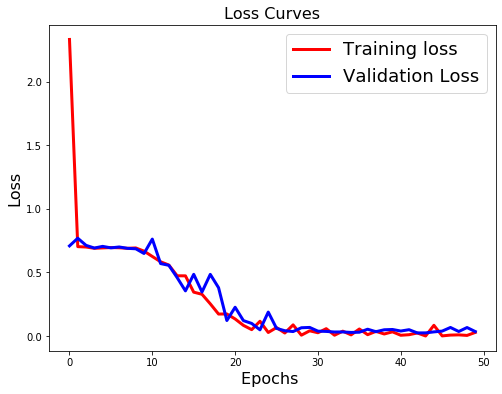

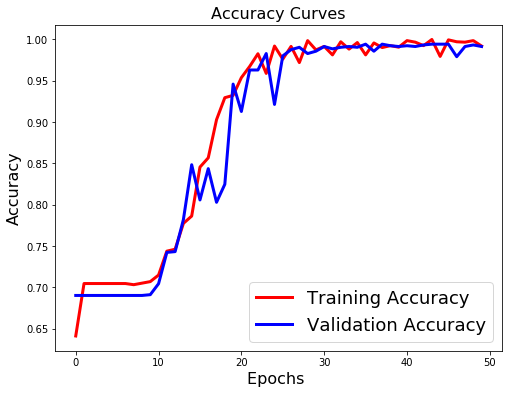

In [26]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history3.history['loss'],'r',linewidth=3.0)
plt.plot(history3.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history3.history['accuracy'],'r',linewidth=3.0)
plt.plot(history3.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Stats

In [27]:
predictions = model3.predict(x_test)

In [28]:
label_predictions = []

for i in predictions.argmax(axis=1):
    if i == 0:
        label_predictions.append('VeryMildDemented')
    elif i == 1:
        label_predictions.append('MildDemented')
    elif i == 2:
        label_predictions.append('ModerateDemented')
    else:
        raise Exception('Index out of range. Please check your predictions.')
        
label_predictions = np.array(label_predictions)

In [29]:
true_labels = []

for i in y_test.argmax(axis=1):
    if i == 0:
        true_labels.append('VeryMildDemented')
    elif i == 1:
        true_labels.append('MildDemented')
    elif i == 2:
        true_labels.append('ModerateDemented')
    else:
        raise Exception('Index out of range. Please check your predictions.')
        
true_labels = np.array(true_labels)

Accuracy: 0.99148
F1: 0.99147
Recall: 0.99148
Precision: 0.99147
Jaccard: 0.98312


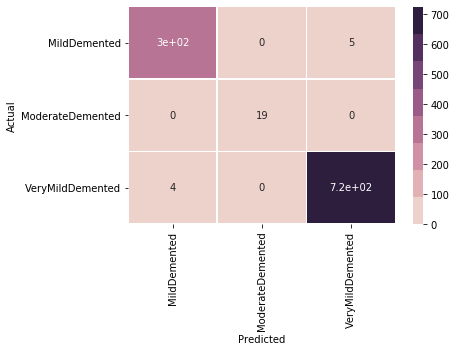

In [30]:
eval3 = Evalulator(true_labels, label_predictions)

eval3.confusion_matrix()
eval3.stats()

# Model v4 (7-4-20) -- w/ SMOTE

In [17]:
model4 = create_model(x_train[0].shape, classes)
batch_size = 100
epochs = 50
model4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(x_train2, y_train, batch_size=batch_size, epochs=epochs, verbose=1\
                     , validation_data=(x_test, y_test))

model4.evaluate(x_test, y_test)

(208, 176, 3) 3
Train on 2511 samples, validate on 1056 samples
Epoch 1/50
2511/2511 [==============================] - 12s 5ms/step - loss: 1.8032 - accuracy: 0.5416 - val_loss: 0.7763 - val_accuracy: 0.6903
Epoch 2/50
2511/2511 [==============================] - 8s 3ms/step - loss: 0.8362 - accuracy: 0.5806 - val_loss: 0.8808 - val_accuracy: 0.2917
Epoch 3/50
2511/2511 [==============================] - 8s 3ms/step - loss: 0.7977 - accuracy: 0.5914 - val_loss: 0.7052 - val_accuracy: 0.6903
Epoch 4/50
2511/2511 [==============================] - 8s 3ms/step - loss: 0.7932 - accuracy: 0.5830 - val_loss: 0.7371 - val_accuracy: 0.6903
Epoch 5/50
2511/2511 [==============================] - 8s 3ms/step - loss: 0.7918 - accuracy: 0.6037 - val_loss: 0.6759 - val_accuracy: 0.6884
Epoch 6/50
2511/2511 [==============================] - 8s 3ms/step - loss: 0.7587 - accuracy: 0.6217 - val_loss: 0.6958 - val_accuracy: 0.7017
Epoch 7/50
2511/2511 [==============================] - 8s 3ms/step - l

[0.029834276604974133, 0.9943181872367859]

In [18]:
model4.save('models/model_v4_07-04-2020')

Text(0.5, 1.0, 'Accuracy Curves')

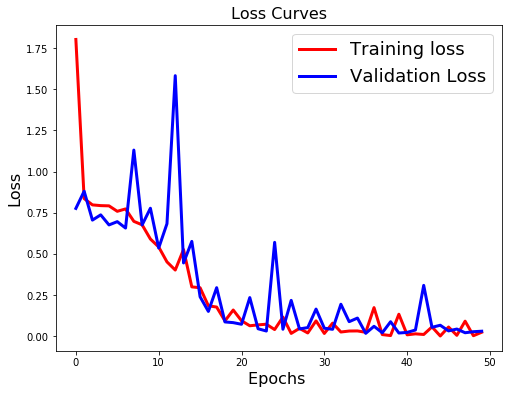

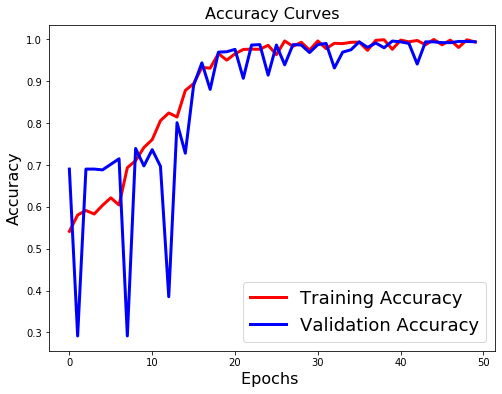

In [19]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history4.history['loss'],'r',linewidth=3.0)
plt.plot(history4.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history4.history['accuracy'],'r',linewidth=3.0)
plt.plot(history4.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Stats

In [20]:
predictions = model4.predict(x_test)

In [21]:
label_predictions = []

for i in predictions.argmax(axis=1):
    if i == 0:
        label_predictions.append('VeryMildDemented')
    elif i == 1:
        label_predictions.append('MildDemented')
    elif i == 2:
        label_predictions.append('ModerateDemented')
    else:
        raise Exception('Index out of range. Please check your predictions.')
        
label_predictions = np.array(label_predictions)

In [22]:
true_labels = []

for i in y_test.argmax(axis=1):
    if i == 0:
        true_labels.append('VeryMildDemented')
    elif i == 1:
        true_labels.append('MildDemented')
    elif i == 2:
        true_labels.append('ModerateDemented')
    else:
        raise Exception('Index out of range. Please check your predictions.')
        
true_labels = np.array(true_labels)

Accuracy: 0.99432
F1: 0.99432
Recall: 0.99432
Precision: 0.99434
Jaccard: 0.98872


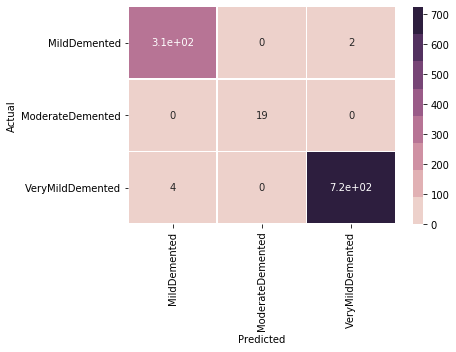

In [23]:
eval4 = Evalulator(true_labels, label_predictions)

eval4.confusion_matrix()
eval4.stats()